In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sparse_stoch_mat_central as sp_stoch_mat
import sys
from scipy.sparse.linalg import spsolve
import timeit
from functions import *
from phys_functions import physfcts 

plt.rcParams['figure.facecolor'] = 'white'

## Equation differential of the problem :
^ wtf this is French accent
$$ 
\begin{cases}
&\partial_t \rho_a = \partial_x^2 \rho_a +\partial_x[\rho_a \partial_x V_a] + \rho_b k_{ba} + \rho_c k_{ca} - \rho_a(k_{ac}+k_{ab})\\
&\partial_t \rho_b = \partial_x^2 \rho_b +\partial_x[\rho_b \partial_x V_b] + \rho_a k_{ab} + \rho_c k_{cb} - \rho_b(k_{bc}+k_{ba})\\
&\partial_t \rho_c = \partial_x^2 \rho_c +\partial_x[\rho_c \partial_x V_c] + \rho_a k_{ac} + \rho_b k_{bc} - \rho_c(k_{ca}+k_{cb})\\
\end{cases}
$$
with :
$$
\begin{cases}
&k_{ab} = k_{ab}^0 e^{-\epsilon_{ab}+V_a}A_{ab} \hspace{1cm} k_{bc} = k_{bc}^0e^{-\text{max}(V_c-V_b,0)+\epsilon_{bc}}A_{bc} \hspace{1cm} k_{ac} = k_{ac}^0 e^{-\text{max}(V_c-V_a,0)+\epsilon_{ac}}A_{ac}\\
&k_{ba} = k_{ab}^0 e^{-\text{max}(V_a-V_b,0)+\epsilon_{ab}} \hspace{1cm} k_{cb} = k_{bc}^0e^{-\text{max}(V_b-V_c,0)+\epsilon_{bc}} \hspace{1cm} k_{ca} = k_{ac}^0 e^{-\text{max}(V_a-V_c,0)+\epsilon_{ac}}
\end{cases}
$$
Where $V_a$, $V_b$, and $V_c$ are the space dependent potential that affect respectively $a$, $b$, $c$, $A_{ab}$, $A_{bc}$, $A_{ac}$ are respectively the activity brought to the reaction $a\rightarrow b$, $b\rightarrow c$, $a\rightarrow c$. the $k^0$ will define time units.

In [2]:
eta = 0.0001
V0a, V0b, V0c = 0.,0.,0.
V1a, V1b, V1c = .5,1.,1.5
signA, signB, signC = 1,1,1
per = 1
Eab0,Ebc0,Eac0 = .5,.7,1. 
kab0,kbc0,kac0 = 1.,1.,1. 
mu = 1.5
Aab,Abc,Aac = 1.,1.,mu # != 1 -> ooe
X0,Xf,n = -1,1,10000 # lower/higher spacial boundary and number of discretizing points
dx = (Xf-X0)/n
print('dx = '+str(dx))

X = np.linspace(X0,Xf,n,endpoint=False)

dx = 0.0002


In [3]:
vars = np.array([eta, kab0, kbc0, kac0, Eab0, Ebc0, Eac0, V0a, V0b, V0c, V1a, V1b, V1c, Aab, Abc, Aac, signA, signB, signC, per, X0, Xf, n, dx])
f = physfcts(vars)

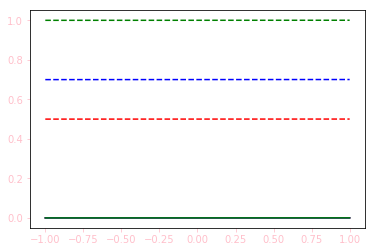

In [4]:
ColorCycle = np.array(['red', 'blue', 'green', 'cyan', 'pink', 'magenta','black', 'gray'])
plt.plot(X, f.Va_out(X), 'r')
plt.plot(X, f.Vb_out(X), 'b')
plt.plot(X, f.Vc_out(X), 'g')
plt.plot(X, f.Eab(X), 'r--')
plt.plot(X, f.Ebc(X), 'b--')
plt.plot(X, f.Eac(X), 'g--')
plt.tick_params(axis='y', colors='pink')
plt.tick_params(axis='x', colors='pink')

In [5]:
# we first compute the non-normalized diffusion part : 
rho_a_diff,rho_b_diff,rho_c_diff = make_eq_distrib(f.Va_out,f.Vb_out,f.Vc_out,np.linspace(X0,Xf,n,endpoint=False))
# compute the normalization
Z = (sum(rho_a_diff)+sum(rho_b_diff)+sum(rho_c_diff))*dx
# normalize the diffusion part :
rho_a_diff,rho_b_diff,rho_c_diff =rho_a_diff/Z,rho_b_diff/Z,rho_c_diff/Z

In [6]:
Eq_Stoch_Mat = sp_stoch_mat.make_transition_matrix(f.Va_out,f.Vb_out,f.Vc_out,
                                    f.kab_out,f.kba_out,f.kbc_out,f.kcb_out,f.kac_out,f.kca_out,
                                    kab0,kbc0,kac0,
                                    Aab=1.,Abc=1.,Aac=1.,
                                    X0=X0,Xf=Xf,n=n)
rho_a_eq,rho_b_eq,rho_c_eq = get_kernel_stoch_mat(Eq_Stoch_Mat,dx)

In [7]:
rho_a_ooe,rho_b_ooe,rho_c_ooe = f.NumRhos()
rho_a_m, rho_b_m, rho_c_m = f.MathRhos(X)

## Plot the analytical and the numerical solution together 
incl. the numerical uncertainty of the numerical solution.

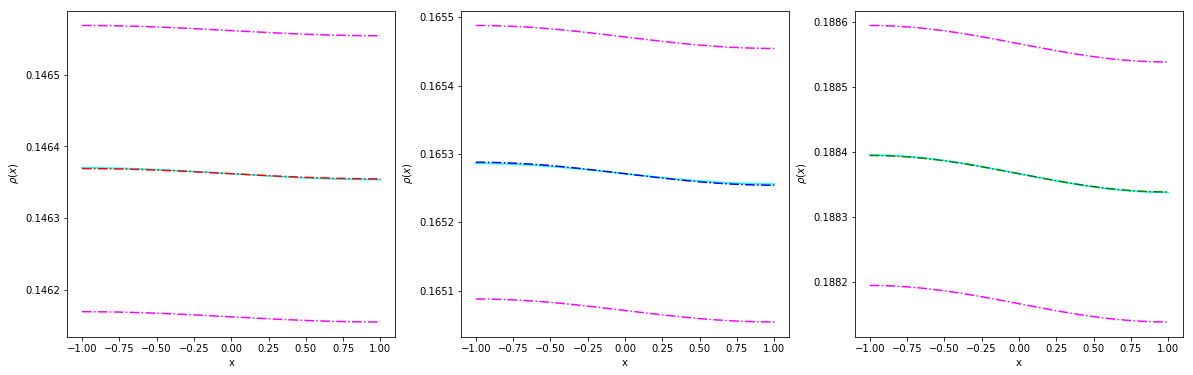

In [8]:
fig,ax = plt.subplots(ncols=3,figsize=(20,6), facecolor = 'white')

ax[0].plot(X,rho_a_m,color = ColorCycle[3],label='mathematica')
ax[0].plot(X,rho_a_ooe,color = ColorCycle[0],linestyle='-.',label='ooe solution')
ax[0].plot(X,rho_a_ooe-dx,color = ColorCycle[5],linestyle='-.')
ax[0].plot(X,rho_a_ooe+dx,color = ColorCycle[5],linestyle='-.')
diff0 = np.abs(rho_a_ooe[9999]-rho_a_ooe[5000])
#ax[0].set_ylim(rho_a_ooe[5000]-np.maximum(diff0,dx)-dx,rho_a_ooe[5000]+np.maximum(diff0,dx)+dx)

ax[1].plot(X,rho_b_m,color = ColorCycle[3],label='mathematica')
ax[1].plot(X,rho_b_ooe,color = ColorCycle[1],linestyle='-.',label='ooe solution')
ax[1].plot(X,rho_b_ooe-dx,color = ColorCycle[5],linestyle='-.')
ax[1].plot(X,rho_b_ooe+dx,color = ColorCycle[5],linestyle='-.')
diff1 = np.abs(rho_b_ooe[9999]-rho_b_ooe[5000])

ax[2].plot(X,rho_c_m,color = ColorCycle[3],label='mathematica')
ax[2].plot(X,rho_c_ooe,color = ColorCycle[2],linestyle='-.',label='ooe solution')
ax[2].plot(X,rho_c_ooe-dx,color = ColorCycle[5],linestyle='-.')
ax[2].plot(X,rho_c_ooe+dx,color = ColorCycle[5],linestyle='-.')
diff2 = np.abs(rho_c_ooe[9999]-rho_c_ooe[5000])
for i in range(3):
    ax[i].set_xlabel('x')
    ax[i].set_ylabel(r'$\rho(x)$')


For eta*V > 0.01, the *equilibrium* solutions stop agreeing. As can be seen in the Mathematica code for the fluxes, the first order is not dominant for eta < 0.001. Hence, also here it is advisable to choose eta < 0.001, which results is good agreement between the two rho's. Quite satisfyingly.



## Look at the fluxes

In [9]:
A_eq_diff__diff_flux = f.diff_flux(rho_a_diff,f.Va_out(X))
A_ooe__diff_flux = f.diff_flux(rho_a_ooe,f.Va_out(X))

B_eq_diff__diff_flux = f.diff_flux(rho_b_diff,f.Vb_out(X))
B_ooe__diff_flux = f.diff_flux(rho_b_ooe,f.Vb_out(X))

C_eq_diff__diff_flux = f.diff_flux(rho_c_diff,f.Vc_out(X))
C_ooe__diff_flux = f.diff_flux(rho_c_ooe,f.Vc_out(X))

## Look at how the fluxes change with the periodicity of the sine (and the steepness)

In [10]:
def rho_fct_per(per_var):
    var_int = np.array([eta, kab0, kbc0, kac0, Eab0, Ebc0, Eac0, V0a, V0b, V0c, V1a, V1b, V1c, Aab, Abc, Aac, signA, signB, signC, per_var, X0, Xf, n, dx])
    fint = physfcts(var_int)
    A_ooe, B_ooe, C_ooe = fint.NumRhos()
    A_m_ooe, B_m_ooe, C_m_ooe = fint.MathRhos(X)
    return A_ooe, B_ooe, C_ooe, A_m_ooe, B_m_ooe, C_m_ooe

Text(0, 0.5, '$\\rho(x,11.)$')

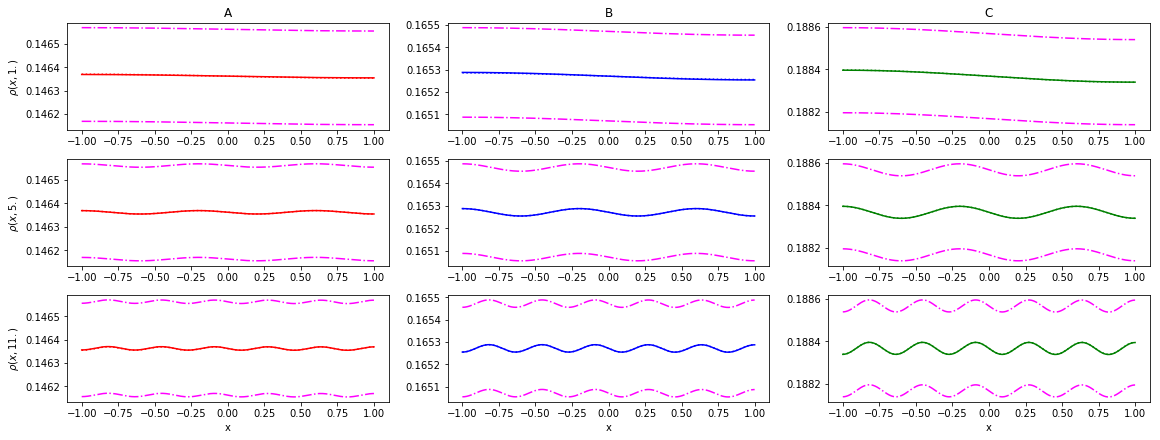

In [11]:
fig,ax = plt.subplots(ncols=3, nrows = 3,figsize=(16,6), constrained_layout = True, facecolor = 'white')

ax[0,0].plot(X,rho_fct_per(1.)[0],color = ColorCycle[0],linestyle='-',label='A, 1.')
ax[0,1].plot(X,rho_fct_per(1.)[1],color = ColorCycle[1],linestyle='-',label='B, 1.')
ax[0,2].plot(X,rho_fct_per(1.)[2],color = ColorCycle[2],linestyle='-',label='C, 1.')
ax[0,0].plot(X,rho_fct_per(1.)[3],color = ColorCycle[0],linestyle=':',label='A, 1.')
ax[0,1].plot(X,rho_fct_per(1.)[4],color = ColorCycle[1],linestyle=':',label='B, 1.')
ax[0,2].plot(X,rho_fct_per(1.)[5],color = ColorCycle[2],linestyle=':',label='C, 1.')
ax[0,0].plot(X,rho_fct_per(1.)[0]-dx,color = ColorCycle[5],linestyle='-.')
ax[0,0].plot(X,rho_fct_per(1.)[0]+dx,color = ColorCycle[5],linestyle='-.')
ax[0,1].plot(X,rho_fct_per(1.)[1]-dx,color = ColorCycle[5],linestyle='-.')
ax[0,1].plot(X,rho_fct_per(1.)[1]+dx,color = ColorCycle[5],linestyle='-.')
ax[0,2].plot(X,rho_fct_per(1.)[2]-dx,color = ColorCycle[5],linestyle='-.')
ax[0,2].plot(X,rho_fct_per(1.)[2]+dx,color = ColorCycle[5],linestyle='-.')

ax[1,0].plot(X,rho_fct_per(5.)[0],color = ColorCycle[0],linestyle='-',label='A, 5.')
ax[1,1].plot(X,rho_fct_per(5.)[1],color = ColorCycle[1],linestyle='-',label='B, 5.')
ax[1,2].plot(X,rho_fct_per(5.)[2],color = ColorCycle[2],linestyle='-',label='C, 5.')
ax[1,0].plot(X,rho_fct_per(5.)[3],color = ColorCycle[0],linestyle=':',label='A, 5.')
ax[1,1].plot(X,rho_fct_per(5.)[4],color = ColorCycle[1],linestyle=':',label='B, 5.')
ax[1,2].plot(X,rho_fct_per(5.)[5],color = ColorCycle[2],linestyle=':',label='C, 5.')
ax[1,0].plot(X,rho_fct_per(5.)[0]-dx,color = ColorCycle[5],linestyle='-.')
ax[1,0].plot(X,rho_fct_per(5.)[0]+dx,color = ColorCycle[5],linestyle='-.')
ax[1,1].plot(X,rho_fct_per(5.)[1]-dx,color = ColorCycle[5],linestyle='-.')
ax[1,1].plot(X,rho_fct_per(5.)[1]+dx,color = ColorCycle[5],linestyle='-.')
ax[1,2].plot(X,rho_fct_per(5.)[2]-dx,color = ColorCycle[5],linestyle='-.')
ax[1,2].plot(X,rho_fct_per(5.)[2]+dx,color = ColorCycle[5],linestyle='-.')


ax[2,0].plot(X,rho_fct_per(11.)[0],color = ColorCycle[0],linestyle='-',label='A, 11.')
ax[2,1].plot(X,rho_fct_per(11.)[1],color = ColorCycle[1],linestyle='-',label='B, 11.')
ax[2,2].plot(X,rho_fct_per(11.)[2],color = ColorCycle[2],linestyle='-',label='C, 11.')
ax[2,0].plot(X,rho_fct_per(11.)[3],color = ColorCycle[0],linestyle=':',label='A, 11.')
ax[2,1].plot(X,rho_fct_per(11.)[4],color = ColorCycle[1],linestyle=':',label='B, 11.')
ax[2,2].plot(X,rho_fct_per(11.)[5],color = ColorCycle[2],linestyle=':',label='C, 11.')
ax[2,0].plot(X,rho_fct_per(11.)[0]-dx,color = ColorCycle[5],linestyle='-.')
ax[2,0].plot(X,rho_fct_per(11.)[0]+dx,color = ColorCycle[5],linestyle='-.')
ax[2,1].plot(X,rho_fct_per(11.)[1]-dx,color = ColorCycle[5],linestyle='-.')
ax[2,1].plot(X,rho_fct_per(11.)[1]+dx,color = ColorCycle[5],linestyle='-.')
ax[2,2].plot(X,rho_fct_per(11.)[2]-dx,color = ColorCycle[5],linestyle='-.')
ax[2,2].plot(X,rho_fct_per(11.)[2]+dx,color = ColorCycle[5],linestyle='-.')

ax[0,0].set_title('A')
ax[0,1].set_title('B')
ax[0,2].set_title('C')

for i in range(3):
    ax[2,i].set_xlabel('x')
ax[0,0].set_ylabel(r'$\rho(x,1.)$')
ax[1,0].set_ylabel(r'$\rho(x,5.)$')
ax[2,0].set_ylabel(r'$\rho(x,11.)$')


In [12]:
def difference_bw_rho_fct_per(per_var):
    var_int = np.array([eta, kab0, kbc0, kac0, Eab0, Ebc0, Eac0, V0a, V0b, V0c, V1a, V1b, V1c, Aab, Abc, Aac, signA, signB, signC, per_var, X0, Xf, n, dx])
    fint = physfcts(var_int)
    A_ooe, B_ooe, C_ooe = fint.NumRhos()
    A_m_ooe, B_m_ooe, C_m_ooe = fint.MathRhos(X)
    return A_ooe, B_ooe, C_ooe, A_m_ooe, B_m_ooe, C_m_ooe

In [13]:
def drho_fct_per(per_var):
    var_int = np.array([eta, kab0, kbc0, kac0, Eab0, Ebc0, Eac0, V0a, V0b, V0c, V1a, V1b, V1c, Aab, Abc, Aac, signA, signB, signC, per_var, X0, Xf, n, dx])
    fint = physfcts(var_int)
    A_ooe, B_ooe, C_ooe = fint.NumRhos()
    A_m_ooe, B_m_ooe, C_m_ooe = fint.MathRhos(X)
    return D(A_ooe,dx), D(B_ooe,dx), D(C_ooe,dx), D(A_m_ooe,dx) , D(B_m_ooe,dx), D(C_m_ooe,dx)

In [14]:
def dV_fct_per(per_var):
    var_int = np.array([eta, kab0, kbc0, kac0, Eab0, Ebc0, Eac0, V0a, V0b, V0c, V1a, V1b, V1c, Aab, Abc, Aac, signA, signB, signC, per_var, X0, Xf, n, dx])
    fint = physfcts(var_int)
    A_ooe, B_ooe, C_ooe = fint.NumRhos()
    A_m_ooe, B_m_ooe, C_m_ooe = fint.MathRhos(X)
    dVa = D(fint.Va_out(X),dx)
    dVb = D(fint.Vb_out(X),dx)
    dVc = D(fint.Vc_out(X),dx)
    dVa_m = np.pi*per_var* signA *V1a*eta*np.cos(per_var*np.pi*X/2)/2
    dVb_m = np.pi*per_var* signB *V1b*eta*np.cos(per_var*np.pi*X/2)/2
    dVc_m = np.pi*per_var* signC *V1c*eta*np.cos(per_var*np.pi*X/2)/2
    return A_ooe*dVa, B_ooe*dVb, C_ooe*dVc, A_m_ooe*dVa_m, B_m_ooe*dVb_m, C_m_ooe*dVc_m

In [15]:
def fluxexpl_fct_per(per_var):
    drho1, drho2, drho3, drho4, drho5, drho6 = drho_fct_per(per_var)
    dv1, dv2, dv3, dv4, dv5, dv6 = dV_fct_per(per_var)
    return drho1+dv1, drho2+dv2, drho3+dv3, drho4+dv4, drho5+dv5, drho6+dv6

In [16]:
def flux_fct_per(per_var):
    var_int = np.array([eta, kab0, kbc0, kac0, Eab0, Ebc0, Eac0, V0a, V0b, V0c, V1a, V1b, V1c, Aab, Abc, Aac, signA, signB, signC, per_var, X0, Xf, n, dx])
    fint = physfcts(var_int)
    rho_a_ooe, rho_b_ooe, rho_c_ooe = fint.NumRhos()
    A_ooe = fint.diff_flux(rho_a_ooe,fint.Va_out(X))
    B_ooe = fint.diff_flux(rho_b_ooe,fint.Vb_out(X))
    C_ooe = fint.diff_flux(rho_c_ooe,fint.Vc_out(X))
    A_m_ooe, B_m_ooe, C_m_ooe = fint.flux_ana(X)
    return A_ooe, B_ooe, C_ooe, A_m_ooe, B_m_ooe, C_m_ooe

Text(0, 0.5, '$\\rho_n(x,5.)-\\rho_a(x,5.)$')

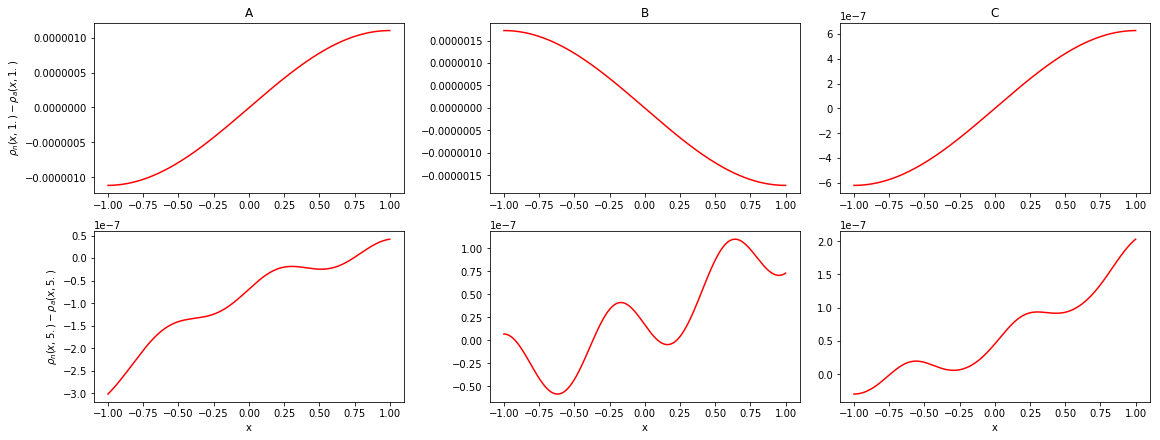

In [17]:
fig,ax = plt.subplots(ncols=3, nrows = 2,figsize=(16,6), constrained_layout = True, facecolor = 'white')

ax[0,0].plot(X,difference_bw_rho_fct_per(1.)[0]-difference_bw_rho_fct_per(1.)[3],color = ColorCycle[0],linestyle='-',label='A, 1.')
ax[0,1].plot(X,difference_bw_rho_fct_per(1.)[1]-difference_bw_rho_fct_per(1.)[4],color = ColorCycle[0],linestyle='-',label='B, 1.')
ax[0,2].plot(X,difference_bw_rho_fct_per(1.)[2]-difference_bw_rho_fct_per(1.)[5],color = ColorCycle[0],linestyle='-',label='C, 1.')

ax[1,0].plot(X,difference_bw_rho_fct_per(5.)[0]-difference_bw_rho_fct_per(5.)[3],color = ColorCycle[0],linestyle='-',label='A, 5.')
ax[1,1].plot(X,difference_bw_rho_fct_per(5.)[1]-difference_bw_rho_fct_per(5.)[4],color = ColorCycle[0],linestyle='-',label='B, 5.')
ax[1,2].plot(X,difference_bw_rho_fct_per(5.)[2]-difference_bw_rho_fct_per(5.)[5],color = ColorCycle[0],linestyle='-',label='C, 5.')

ax[0,0].set_title('A')
ax[0,1].set_title('B')
ax[0,2].set_title('C')

for i in range(3):
    ax[1,i].set_xlabel('x')
ax[0,0].set_ylabel(r'$\rho_n(x,1.)-\rho_a(x,1.)$')
ax[1,0].set_ylabel(r'$\rho_n(x,5.)-\rho_a(x,5.)$')


So this is the infinitessimal difference between the analytical and numerical rhos, which is way under the precision of the codes, but which propagates to f up the fluxes. 

Text(0, 0.5, '$\\rho_n(x,5.)$')

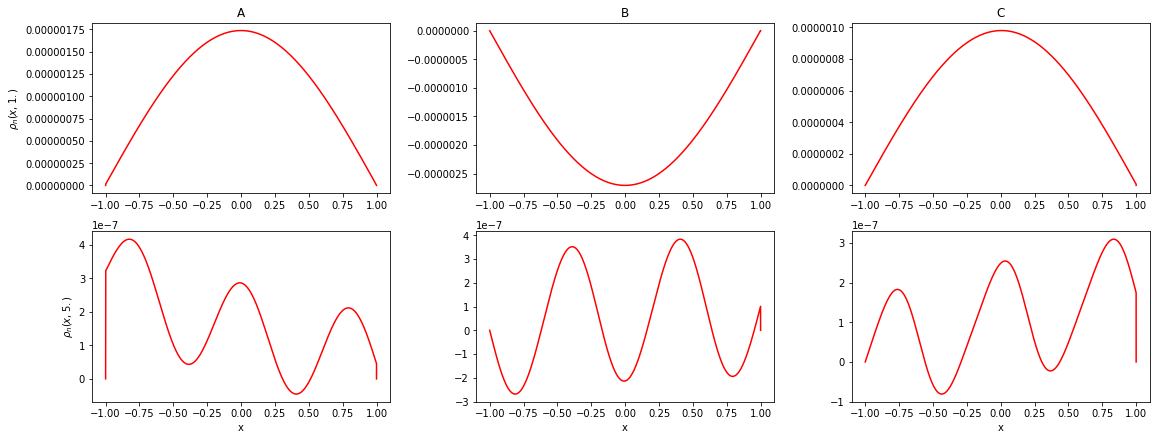

In [18]:
fig,ax = plt.subplots(ncols=3, nrows = 2,figsize=(16,6), constrained_layout = True, facecolor = 'white')

ax[0,0].plot(X,drho_fct_per(1.)[0]-drho_fct_per(1.)[3],color = ColorCycle[0],linestyle='-',label='A, 1.')
ax[0,1].plot(X,drho_fct_per(1.)[1]-drho_fct_per(1.)[4],color = ColorCycle[0],linestyle='-',label='B, 1.')
ax[0,2].plot(X,drho_fct_per(1.)[2]-drho_fct_per(1.)[5],color = ColorCycle[0],linestyle='-',label='C, 1.')

ax[1,0].plot(X,drho_fct_per(5.)[0]-drho_fct_per(5.)[3],color = ColorCycle[0],linestyle='-',label='A, 5.')
ax[1,1].plot(X,drho_fct_per(5.)[1]-drho_fct_per(5.)[4],color = ColorCycle[0],linestyle='-',label='B, 5.')
ax[1,2].plot(X,drho_fct_per(5.)[2]-drho_fct_per(5.)[5],color = ColorCycle[0],linestyle='-',label='C, 5.')

ax[0,0].set_title('A')
ax[0,1].set_title('B')
ax[0,2].set_title('C')

for i in range(3):
    ax[1,i].set_xlabel('x')
ax[0,0].set_ylabel(r'$\rho_n(x,1.)$')
ax[1,0].set_ylabel(r'$\rho_n(x,5.)$')

Text(0, 0.5, '$\\rho \\cdot dV/dx(x,5.)$')

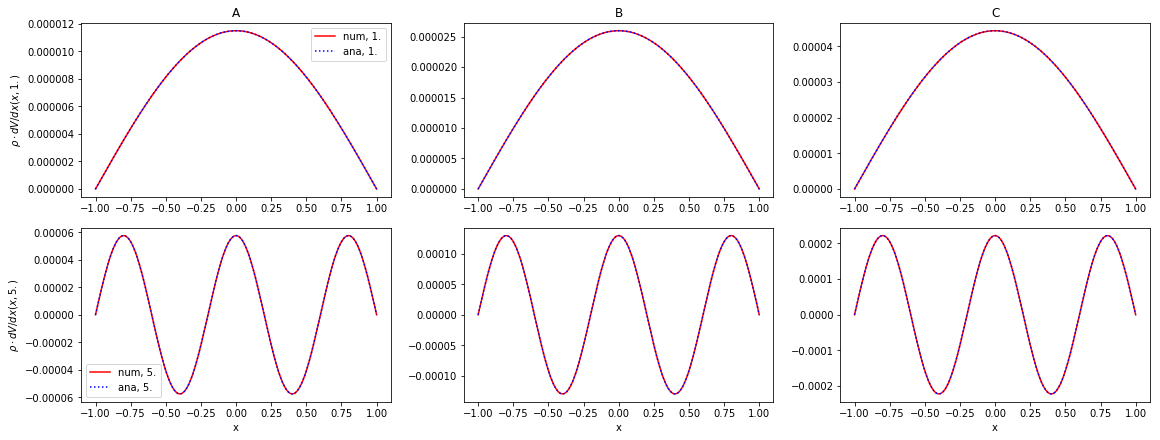

In [19]:
fig,ax = plt.subplots(ncols=3, nrows = 2,figsize=(16,6), constrained_layout = True, facecolor = 'white')

ax[0,0].plot(X,dV_fct_per(1.)[0],color = ColorCycle[0],linestyle='-',label='num, 1.')
ax[0,1].plot(X,dV_fct_per(1.)[1],color = ColorCycle[0],linestyle='-')
ax[0,2].plot(X,dV_fct_per(1.)[2],color = ColorCycle[0],linestyle='-')
ax[0,0].plot(X,dV_fct_per(1.)[3],color = ColorCycle[1],linestyle=':',label='ana, 1.')
ax[0,1].plot(X,dV_fct_per(1.)[4],color = ColorCycle[1],linestyle=':')
ax[0,2].plot(X,dV_fct_per(1.)[5],color = ColorCycle[1],linestyle=':')


ax[1,0].plot(X,dV_fct_per(5.)[0],color = ColorCycle[0],linestyle='-',label='num, 5.')
ax[1,1].plot(X,dV_fct_per(5.)[1],color = ColorCycle[0],linestyle='-')
ax[1,2].plot(X,dV_fct_per(5.)[2],color = ColorCycle[0],linestyle='-')
ax[1,0].plot(X,dV_fct_per(5.)[3],color = ColorCycle[1],linestyle=':',label='ana, 5.')
ax[1,1].plot(X,dV_fct_per(5.)[4],color = ColorCycle[1],linestyle=':')
ax[1,2].plot(X,dV_fct_per(5.)[5],color = ColorCycle[1],linestyle=':')

ax[0,0].set_title('A')
ax[0,1].set_title('B')
ax[0,2].set_title('C')

for i in range(3):
    ax[1,i].set_xlabel('x')
    
ax[0,0].legend()
ax[1,0].legend()
ax[0,0].set_ylabel(r'$\rho \cdot dV/dx(x,1.)$')
ax[1,0].set_ylabel(r'$\rho \cdot dV/dx(x,5.)$')


Text(0, 0.5, '$d\\rho/dx+\\rho \\cdot dV/dx(x,5.)$')

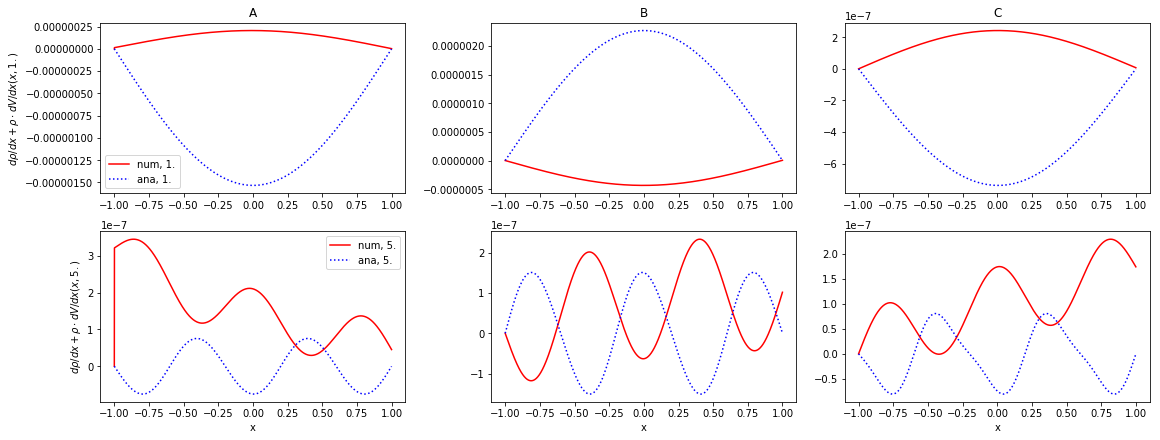

In [20]:
fig,ax = plt.subplots(ncols=3, nrows = 2,figsize=(16,6), constrained_layout = True, facecolor = 'white')


ax[0,0].plot(X[:-1],fluxexpl_fct_per(1.)[0][:-1],color = ColorCycle[0],linestyle='-',label='num, 1.')
ax[0,1].plot(X[:-1],fluxexpl_fct_per(1.)[1][:-1],color = ColorCycle[0],linestyle='-')
ax[0,2].plot(X[:-1],fluxexpl_fct_per(1.)[2][:-1],color = ColorCycle[0],linestyle='-')
ax[0,0].plot(X[:-1],fluxexpl_fct_per(1.)[3][:-1],color = ColorCycle[1],linestyle=':',label='ana, 1.')
ax[0,1].plot(X[:-1],fluxexpl_fct_per(1.)[4][:-1],color = ColorCycle[1],linestyle=':')
ax[0,2].plot(X[:-1],fluxexpl_fct_per(1.)[5][:-1],color = ColorCycle[1],linestyle=':')


ax[1,0].plot(X[:-1],fluxexpl_fct_per(5.)[0][:-1],color = ColorCycle[0],linestyle='-',label='num, 5.')
ax[1,1].plot(X[:-1],fluxexpl_fct_per(5.)[1][:-1],color = ColorCycle[0],linestyle='-')
ax[1,2].plot(X[:-1],fluxexpl_fct_per(5.)[2][:-1],color = ColorCycle[0],linestyle='-')
ax[1,0].plot(X[:-1],fluxexpl_fct_per(5.)[3][:-1],color = ColorCycle[1],linestyle=':',label='ana, 5.')
ax[1,1].plot(X[:-1],fluxexpl_fct_per(5.)[4][:-1],color = ColorCycle[1],linestyle=':')
ax[1,2].plot(X[:-1],fluxexpl_fct_per(5.)[5][:-1],color = ColorCycle[1],linestyle=':')

ax[0,0].set_title('A')
ax[0,1].set_title('B')
ax[0,2].set_title('C')

ax[0,0].legend()
ax[1,0].legend()

for i in range(3):
    ax[1,i].set_xlabel('x')
ax[0,0].set_ylabel(r'$d\rho/dx+\rho \cdot dV/dx(x,1.)$')
ax[1,0].set_ylabel(r'$d\rho/dx+\rho \cdot dV/dx(x,5.)$')

In [21]:
X

array([-1.    , -0.9998, -0.9996, ...,  0.9994,  0.9996,  0.9998])

In [22]:
fluxexpl_fct_per(5.)[3][-50:-1]

array([-6.14386143e-09, -6.02127629e-09, -5.89863024e-09, -5.77597877e-09,
       -5.65337734e-09, -5.53074258e-09, -5.40799114e-09, -5.28524777e-09,
       -5.16256783e-09, -5.03986787e-09, -4.91706443e-09, -4.79435156e-09,
       -4.67164576e-09, -4.54879409e-09, -4.42605995e-09, -4.30329036e-09,
       -4.18033235e-09, -4.05751863e-09, -3.93476557e-09, -3.81185073e-09,
       -3.68903739e-09, -3.56617247e-09, -3.44324166e-09, -3.32036941e-09,
       -3.19747198e-09, -3.07460439e-09, -2.95161350e-09, -2.82869309e-09,
       -2.70582874e-09, -2.58286727e-09, -2.45993303e-09, -2.33694219e-09,
       -2.21394969e-09, -2.09101046e-09, -1.96804064e-09, -1.84509514e-09,
       -1.72209009e-09, -1.59908037e-09, -1.47619026e-09, -1.35312770e-09,
       -1.23008633e-09, -1.10719041e-09, -9.84078457e-10, -8.61013503e-10,
       -7.38119785e-10, -6.15174591e-10, -4.92093990e-10, -3.69002209e-10,
       -2.46023476e-10])

In [23]:
fluxexpl_fct_per(5.)[0][-20:]

array([4.77208105e-08, 4.75883921e-08, 4.74559753e-08, 4.73236441e-08,
       4.71913434e-08, 4.70589491e-08, 4.69266142e-08, 4.67943534e-08,
       4.66619730e-08, 4.65295569e-08, 4.63971889e-08, 4.62649530e-08,
       4.61325862e-08, 4.60000337e-08, 4.58676568e-08, 4.57353314e-08,
       4.56028638e-08, 4.54703380e-08, 4.53379073e-08, 0.00000000e+00])

Text(0, 0.5, '$d\\rho/dx+\\rho \\cdot dV/dx(x,5.)$')

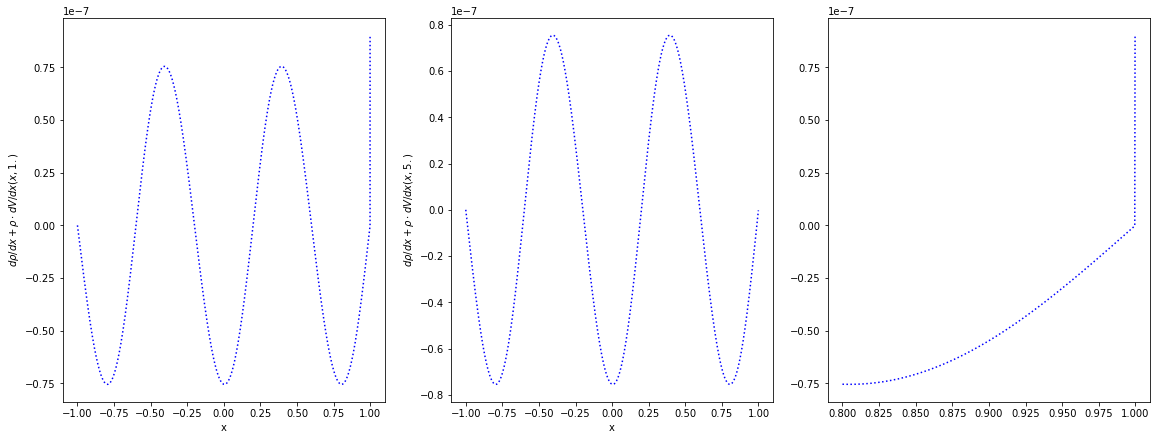

In [24]:
fig,ax = plt.subplots(ncols=3,figsize=(16,6), constrained_layout = True, facecolor = 'white')

ax[0].plot(X,fluxexpl_fct_per(5.)[3],color = ColorCycle[1],linestyle=':')
ax[1].plot(X[0:-1],fluxexpl_fct_per(5.)[3][0:-1],color = ColorCycle[1],linestyle=':')
ax[2].plot(X[-1000:],fluxexpl_fct_per(5.)[3][-1000:],color = ColorCycle[1],linestyle=':')

for i in range(2):
    ax[i].set_xlabel('x')
ax[0].set_ylabel(r'$d\rho/dx+\rho \cdot dV/dx(x,1.)$')
ax[1].set_ylabel(r'$d\rho/dx+\rho \cdot dV/dx(x,5.)$')

Text(0, 0.5, '$J(x,5.)$')

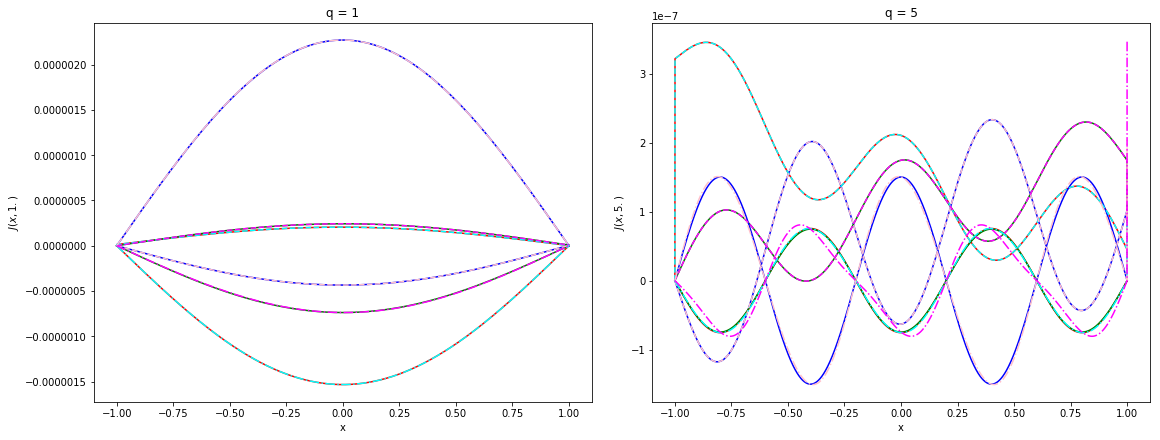

In [19]:
fig,ax = plt.subplots(ncols=2,figsize=(16,6), constrained_layout = True, facecolor = 'white')

ax[0].plot(X,flux_fct_per(1.)[0],color = ColorCycle[0],linestyle='-',label='A, 1.')
ax[0].plot(X,flux_fct_per(1.)[1],color = ColorCycle[1],linestyle='-',label='B, 1.')
ax[0].plot(X,flux_fct_per(1.)[2],color = ColorCycle[2],linestyle='-',label='C, 1.')
ax[0].plot(X,flux_fct_per(1.)[3],color = ColorCycle[0],linestyle='-',label='A, 1.')
ax[0].plot(X,flux_fct_per(1.)[4],color = ColorCycle[1],linestyle='-',label='B, 1.')
ax[0].plot(X,flux_fct_per(1.)[5],color = ColorCycle[2],linestyle='-',label='C, 1.')
ax[0].plot(X,fluxexpl_fct_per(1.)[0],color = ColorCycle[3],linestyle='--',label='A, 1.')
ax[0].plot(X,fluxexpl_fct_per(1.)[1],color = ColorCycle[4],linestyle='--',label='B, 1.')
ax[0].plot(X,fluxexpl_fct_per(1.)[2],color = ColorCycle[5],linestyle='--',label='C, 1.')
ax[0].plot(X,fluxexpl_fct_per(1.)[3],color = ColorCycle[3],linestyle='-.',label='A, 1.')
ax[0].plot(X,fluxexpl_fct_per(1.)[4],color = ColorCycle[4],linestyle='-.',label='B, 1.')
ax[0].plot(X,fluxexpl_fct_per(1.)[5],color = ColorCycle[5],linestyle='-.',label='C, 1.')


ax[1].plot(X,flux_fct_per(5.)[0],color = ColorCycle[0],linestyle='-',label='A, 5.')
ax[1].plot(X,flux_fct_per(5.)[1],color = ColorCycle[1],linestyle='-',label='B, 5.')
ax[1].plot(X,flux_fct_per(5.)[2],color = ColorCycle[2],linestyle='-',label='C, 5.')
ax[1].plot(X,flux_fct_per(5.)[3],color = ColorCycle[0],linestyle='-',label='A, 5.')
ax[1].plot(X,flux_fct_per(5.)[4],color = ColorCycle[1],linestyle='-',label='B, 5.')
ax[1].plot(X,flux_fct_per(5.)[5],color = ColorCycle[2],linestyle='-',label='C, 5.')
ax[1].plot(X,fluxexpl_fct_per(5.)[0],color = ColorCycle[3],linestyle='--',label='A, 5.')
ax[1].plot(X,fluxexpl_fct_per(5.)[1],color = ColorCycle[4],linestyle='--',label='B, 5.')
ax[1].plot(X,fluxexpl_fct_per(5.)[2],color = ColorCycle[5],linestyle='--',label='C, 5.')
ax[1].plot(X,fluxexpl_fct_per(5.)[3],color = ColorCycle[3],linestyle='-.',label='A, 5.')
ax[1].plot(X,fluxexpl_fct_per(5.)[4],color = ColorCycle[4],linestyle='-.',label='B, 5.')
ax[1].plot(X,fluxexpl_fct_per(5.)[5],color = ColorCycle[5],linestyle='-.',label='C, 5.')

ax[0].set_title('q = 1')
ax[1].set_title('q = 5')

for i in range(2):
    ax[i].set_xlabel('x')
ax[0].set_ylabel(r'$J(x,1.)$')
ax[1].set_ylabel(r'$J(x,5.)$')



Nice.

Text(0, 0.5, '$J(x,11.)$')

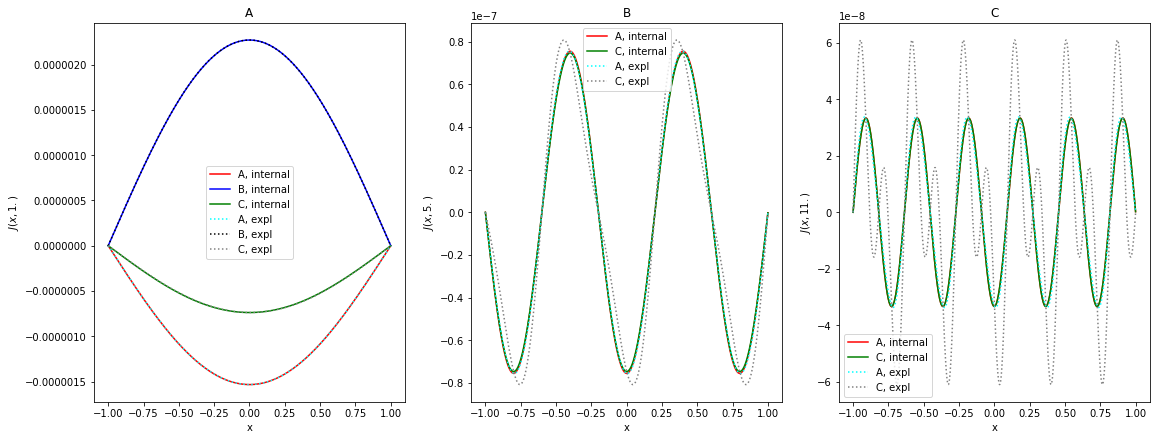

In [26]:
fig,ax = plt.subplots(ncols=3,figsize=(16,6), constrained_layout = True, facecolor = 'white')

ax[0].plot(X[:-1],flux_fct_per(1.)[3][:-1],color = ColorCycle[0],linestyle='-',label='A, internal')
ax[0].plot(X[:-1],flux_fct_per(1.)[4][:-1],color = ColorCycle[1],linestyle='-',label='B, internal')
ax[0].plot(X[:-1],flux_fct_per(1.)[5][:-1],color = ColorCycle[2],linestyle='-',label='C, internal')
ax[0].plot(X[:-1],fluxexpl_fct_per(1.)[3][:-1],color = ColorCycle[3],linestyle=':',label='A, expl')
ax[0].plot(X[:-1],fluxexpl_fct_per(1.)[4][:-1],color = ColorCycle[4],linestyle=':',label='B, expl')
ax[0].plot(X[:-1],fluxexpl_fct_per(1.)[5][:-1],color = ColorCycle[5],linestyle=':',label='C, expl')

ax[1].plot(X[:-1],flux_fct_per(5.)[3][:-1],color = ColorCycle[0],linestyle='-',label='A, internal')
#ax[1].plot(X[:-1],flux_fct_per(5.)[4][:-1],color = ColorCycle[1],linestyle='-',label='B, internal')
ax[1].plot(X[:-1],flux_fct_per(5.)[5][:-1],color = ColorCycle[2],linestyle='-',label='C, internal')
ax[1].plot(X[:-1],fluxexpl_fct_per(5.)[3][:-1],color = ColorCycle[3],linestyle=':',label='A, expl')
#ax[1].plot(X[:-1],fluxexpl_fct_per(5.)[4][:-1],color = ColorCycle[4],linestyle=':',label='B, expl')
ax[1].plot(X[:-1],fluxexpl_fct_per(5.)[5][:-1],color = ColorCycle[5],linestyle=':',label='C, expl')

ax[2].plot(X[:-1],flux_fct_per(11.)[3][:-1],color = ColorCycle[0],linestyle='-',label='A, internal')
#ax[2].plot(X[:-1],flux_fct_per(11.)[4][:-1],color = ColorCycle[1],linestyle='-',label='B, internal')
ax[2].plot(X[:-1],flux_fct_per(11.)[5][:-1],color = ColorCycle[2],linestyle='-',label='C, internal')
ax[2].plot(X[:-1],fluxexpl_fct_per(11.)[3][:-1],color = ColorCycle[3],linestyle=':',label='A, expl')
#ax[2].plot(X[:-1],fluxexpl_fct_per(11.)[4][:-1],color = ColorCycle[4],linestyle=':',label='B, expl')
ax[2].plot(X[:-1],fluxexpl_fct_per(11.)[5][:-1],color = ColorCycle[5],linestyle=':',label='C, expl')

ax[0].set_title('A')
ax[1].set_title('B')
ax[2].set_title('C')

for i in range(3):
    ax[i].set_xlabel('x')
    ax[i].legend()
ax[0].set_ylabel(r'$J(x,1.)$')
ax[1].set_ylabel(r'$J(x,5.)$')
ax[2].set_ylabel(r'$J(x,11.)$')

The analytical fluxes for A and C for high periodicities look identical. Also in Mathematica. 

Text(0, 0.5, '$J(x,11.)$')

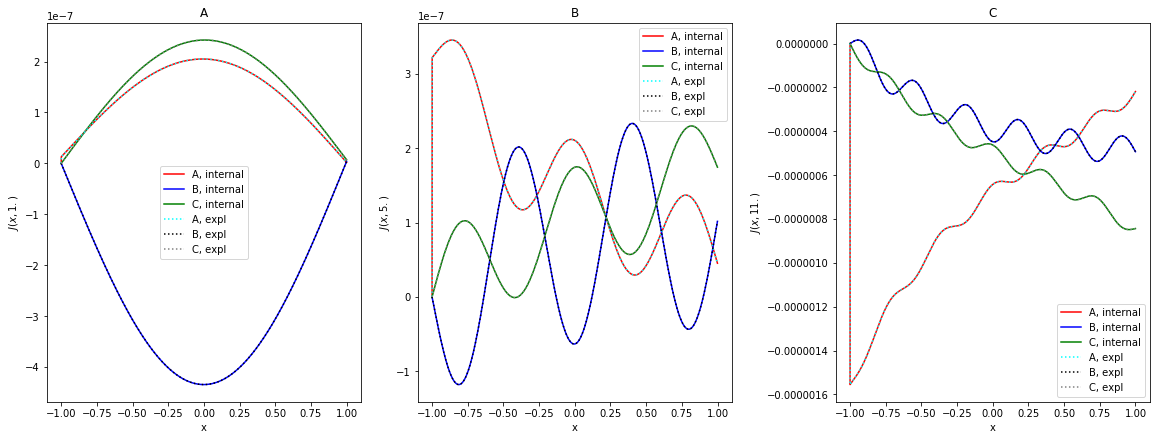

In [33]:
fig,ax = plt.subplots(ncols=3,figsize=(16,6), constrained_layout = True, facecolor = 'white')

ax[0].plot(X[:-1],flux_fct_per(1.)[0][:-1],color = ColorCycle[0],linestyle='-',label='A, internal')
ax[0].plot(X[:-1],flux_fct_per(1.)[1][:-1],color = ColorCycle[1],linestyle='-',label='B, internal')
ax[0].plot(X[:-1],flux_fct_per(1.)[2][:-1],color = ColorCycle[2],linestyle='-',label='C, internal')
ax[0].plot(X[:-1],fluxexpl_fct_per(1.)[0][:-1],color = ColorCycle[3],linestyle=':',label='A, expl')
ax[0].plot(X[:-1],fluxexpl_fct_per(1.)[1][:-1],color = ColorCycle[4],linestyle=':',label='B, expl')
ax[0].plot(X[:-1],fluxexpl_fct_per(1.)[2][:-1],color = ColorCycle[5],linestyle=':',label='C, expl')

ax[1].plot(X[:-1],flux_fct_per(5.)[0][:-1],color = ColorCycle[0],linestyle='-',label='A, internal')
ax[1].plot(X[:-1],flux_fct_per(5.)[1][:-1],color = ColorCycle[1],linestyle='-',label='B, internal')
ax[1].plot(X[:-1],flux_fct_per(5.)[2][:-1],color = ColorCycle[2],linestyle='-',label='C, internal')
ax[1].plot(X[:-1],fluxexpl_fct_per(5.)[0][:-1],color = ColorCycle[3],linestyle=':',label='A, expl')
ax[1].plot(X[:-1],fluxexpl_fct_per(5.)[1][:-1],color = ColorCycle[4],linestyle=':',label='B, expl')
ax[1].plot(X[:-1],fluxexpl_fct_per(5.)[2][:-1],color = ColorCycle[5],linestyle=':',label='C, expl')

ax[2].plot(X[:-1],flux_fct_per(11.)[0][:-1],color = ColorCycle[0],linestyle='-',label='A, internal')
ax[2].plot(X[:-1],flux_fct_per(11.)[1][:-1],color = ColorCycle[1],linestyle='-',label='B, internal')
ax[2].plot(X[:-1],flux_fct_per(11.)[2][:-1],color = ColorCycle[2],linestyle='-',label='C, internal')
ax[2].plot(X[:-1],fluxexpl_fct_per(11.)[0][:-1],color = ColorCycle[3],linestyle=':',label='A, expl')
ax[2].plot(X[:-1],fluxexpl_fct_per(11.)[1][:-1],color = ColorCycle[4],linestyle=':',label='B, expl')
ax[2].plot(X[:-1],fluxexpl_fct_per(11.)[2][:-1],color = ColorCycle[5],linestyle=':',label='C, expl')

ax[0].set_title('A')
ax[1].set_title('B')
ax[2].set_title('C')

for i in range(3):
    ax[i].set_xlabel('x')
    ax[i].legend()
ax[0].set_ylabel(r'$J(x,1.)$')
ax[1].set_ylabel(r'$J(x,5.)$')
ax[2].set_ylabel(r'$J(x,11.)$')

Text(0, 0.5, '$J(x,11.)$')

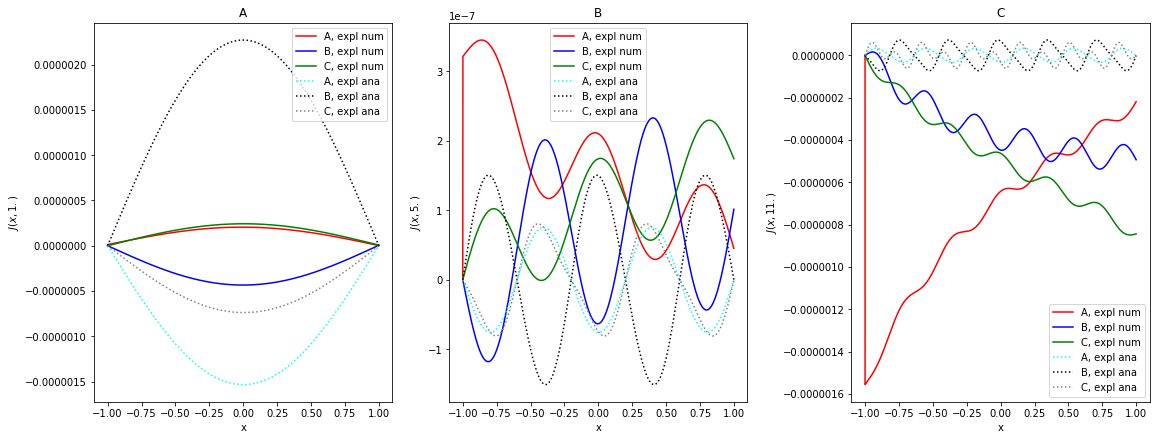

In [32]:
fig,ax = plt.subplots(ncols=3,figsize=(16,6), constrained_layout = True, facecolor = 'white')

ax[0].plot(X[:-1],fluxexpl_fct_per(1.)[0][:-1],color = ColorCycle[0],linestyle='-',label='A, expl num')
ax[0].plot(X[:-1],fluxexpl_fct_per(1.)[1][:-1],color = ColorCycle[1],linestyle='-',label='B, expl num')
ax[0].plot(X[:-1],fluxexpl_fct_per(1.)[2][:-1],color = ColorCycle[2],linestyle='-',label='C, expl num')
ax[0].plot(X[:-1],fluxexpl_fct_per(1.)[3][:-1],color = ColorCycle[3],linestyle=':',label='A, expl ana')
ax[0].plot(X[:-1],fluxexpl_fct_per(1.)[4][:-1],color = ColorCycle[4],linestyle=':',label='B, expl ana')
ax[0].plot(X[:-1],fluxexpl_fct_per(1.)[5][:-1],color = ColorCycle[5],linestyle=':',label='C, expl ana')

ax[1].plot(X[:-1],fluxexpl_fct_per(5.)[0][:-1],color = ColorCycle[0],linestyle='-',label='A, expl num')
ax[1].plot(X[:-1],fluxexpl_fct_per(5.)[1][:-1],color = ColorCycle[1],linestyle='-',label='B, expl num')
ax[1].plot(X[:-1],fluxexpl_fct_per(5.)[2][:-1],color = ColorCycle[2],linestyle='-',label='C, expl num')
ax[1].plot(X[:-1],fluxexpl_fct_per(5.)[3][:-1],color = ColorCycle[3],linestyle=':',label='A, expl ana')
ax[1].plot(X[:-1],fluxexpl_fct_per(5.)[4][:-1],color = ColorCycle[4],linestyle=':',label='B, expl ana')
ax[1].plot(X[:-1],fluxexpl_fct_per(5.)[5][:-1],color = ColorCycle[5],linestyle=':',label='C, expl ana')

ax[2].plot(X[:-1],fluxexpl_fct_per(11.)[0][:-1],color = ColorCycle[0],linestyle='-',label='A, expl num')
ax[2].plot(X[:-1],fluxexpl_fct_per(11.)[1][:-1],color = ColorCycle[1],linestyle='-',label='B, expl num')
ax[2].plot(X[:-1],fluxexpl_fct_per(11.)[2][:-1],color = ColorCycle[2],linestyle='-',label='C, expl num')
ax[2].plot(X[:-1],fluxexpl_fct_per(11.)[3][:-1],color = ColorCycle[3],linestyle=':',label='A, expl ana')
ax[2].plot(X[:-1],fluxexpl_fct_per(11.)[4][:-1],color = ColorCycle[4],linestyle=':',label='B, expl ana')
ax[2].plot(X[:-1],fluxexpl_fct_per(11.)[5][:-1],color = ColorCycle[5],linestyle=':',label='C, expl ana')

ax[0].set_title('A')
ax[1].set_title('B')
ax[2].set_title('C')

for i in range(3):
    ax[i].set_xlabel('x')
    ax[i].legend()
ax[0].set_ylabel(r'$J(x,1.)$')
ax[1].set_ylabel(r'$J(x,5.)$')
ax[2].set_ylabel(r'$J(x,11.)$')

They do not agree, but sorta close.

Text(0, 0.5, '$\\sum J(x,11.)/max(J_A)$')

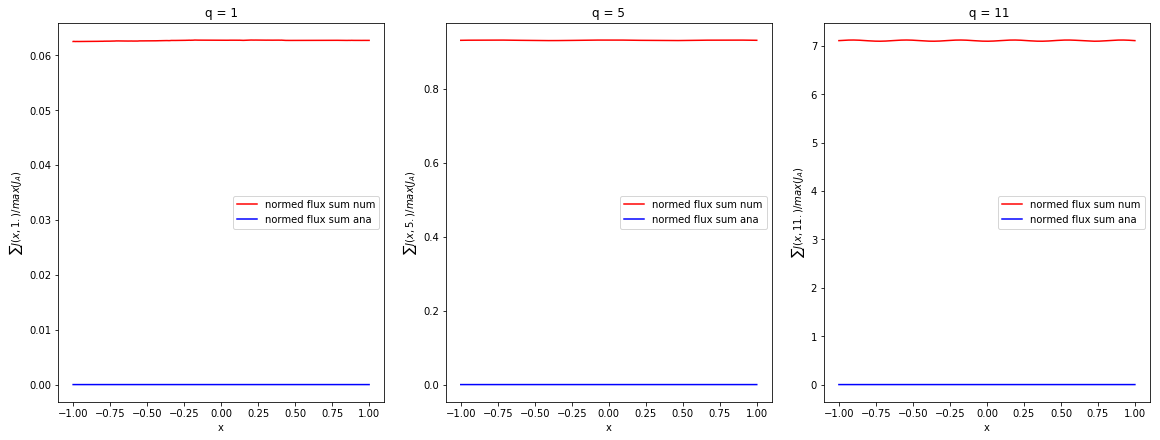

In [32]:
fig,ax = plt.subplots(ncols=3,figsize=(16,6), constrained_layout = True, facecolor = 'white')

ax[0].plot(X[1:-1],(flux_fct_per(1.)[0][1:-1]+flux_fct_per(1.)[1][1:-1]+flux_fct_per(1.)[2][1:-1])/np.max(flux_fct_per(1.)[0][1:-1]),color = ColorCycle[0],linestyle='-',label='normed flux sum num')
ax[0].plot(X[1:-1],(flux_fct_per(1.)[3][1:-1]+flux_fct_per(1.)[4][1:-1]+flux_fct_per(1.)[5][1:-1])/np.max(flux_fct_per(1.)[0][1:-1]),color = ColorCycle[1],linestyle='-',label='normed flux sum ana')

ax[1].plot(X[1:-1],(flux_fct_per(5.)[0][1:-1]+flux_fct_per(5.)[1][1:-1]+flux_fct_per(5.)[2][1:-1])/np.max(flux_fct_per(5.)[0][1:-1]),color = ColorCycle[0],linestyle='-',label='normed flux sum num')
ax[1].plot(X[1:-1],(flux_fct_per(5.)[3][1:-1]+flux_fct_per(5.)[4][1:-1]+flux_fct_per(5.)[5][1:-1])/np.max(flux_fct_per(5.)[0][1:-1]),color = ColorCycle[1],linestyle='-',label='normed flux sum ana')

ax[2].plot(X[1:-1],(flux_fct_per(11.)[0][1:-1]+flux_fct_per(11.)[1][1:-1]+flux_fct_per(11.)[2][1:-1])/np.max(flux_fct_per(11.)[0][1:-1]),color = ColorCycle[0],linestyle='-',label='normed flux sum num')
ax[2].plot(X[1:-1],(flux_fct_per(11.)[3][1:-1]+flux_fct_per(11.)[4][1:-1]+flux_fct_per(11.)[5][1:-1])/np.max(flux_fct_per(11.)[0][1:-1]),color = ColorCycle[1],linestyle='-',label='normed flux sum ana')


ax[0].set_title('q = 1')
ax[1].set_title('q = 5')
ax[2].set_title(' q = 11')

for i in range(3):
    ax[i].set_xlabel('x')
    ax[i].legend()
ax[0].set_ylabel(r'$\sum J(x,1.)/max(J_A)$')
ax[1].set_ylabel(r'$\sum J(x,5.)/max(J_A)$')
ax[2].set_ylabel(r'$\sum J(x,11.)/max(J_A)$')

In [30]:
np.max(flux_fct_per(11.)[0][1:-1])

-2.188235052303223e-07

In [27]:
print(np.sum(flux_fct_per(1.)[0]+flux_fct_per(1.)[1]+flux_fct_per(1.)[2])*dx)
print(np.sum(flux_fct_per(2.)[0]+flux_fct_per(2.)[1]+flux_fct_per(2.)[2])*dx)
print(np.sum(flux_fct_per(5.)[0]+flux_fct_per(5.)[1]+flux_fct_per(5.)[2])*dx)
print(np.sum(flux_fct_per(11.)[0]+flux_fct_per(11.)[1]+flux_fct_per(11.)[2])*dx)
print(np.sum(flux_fct_per(21.)[0]+flux_fct_per(21.)[1]+flux_fct_per(21.)[2])*dx)

2.569097890567428e-08
-0.00010410933063197799
2.5506811205988633e-08
-0.00020837436017214983
2.2298387194807923e-08


Hypermagic cazzi. What's that with the 11 and 21 periodicity?! Why is the flux convoluted with a super low amplitude cosine?

Need to plot fluxes as fct of eta:

ValueError: setting an array element with a sequence.

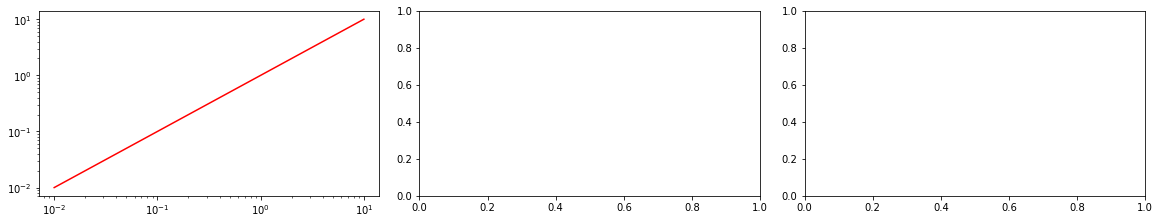

In [28]:
fig,ax = plt.subplots(ncols=3,figsize=(16,3), constrained_layout = True, facecolor = 'white')

def flux_fct_eta(species, eta_var):
    result = np.ones_like(eta_var)
    for i in range(len(eta_var)):
        var_int = np.array([eta_var[i], kab0, kbc0, kac0, Eab0, Ebc0, Eac0, V0a, V0b, V0c, V1a, V1b, V1c, Aab, Abc, Aac, signA, signB, signC, 11., X0, Xf, n, dx])
        fint = physfcts(var_int)
        A_ooe = diff_flux(rho_a_ooe,fint.Va_out(X),dx)
        B_ooe = diff_flux(rho_b_ooe,fint.Vb_out(X),dx)
        C_ooe = diff_flux(rho_c_ooe,fint.Vc_out(X),dx)
        deltaint = fint.flux_cc(X[4999])-fint.flux_cw(X[4999])
        if species == 'A':
            result[i] = A_ooe[4999]/deltaint
        elif species == 'B':
            result[i] = B_ooe[4999]/deltaint
        elif species == 'C':
            result[i] = C_ooe[4999]/deltaint
    return result

eta_array = np.array([0.01,0.1,1,10.])
ax[0].loglog(eta_array,eta_array,'-', color = ColorCycle[0])
ax[0].loglog(eta_array,flux_fct_eta('A',eta_array),'o', color = ColorCycle[0])
ax[0].loglog(eta_array,flux_fct_eta('B',eta_array),'o', color = ColorCycle[1])
ax[0].loglog(eta_array,flux_fct_eta('C',eta_array),'o', color = ColorCycle[2])
ax[1].loglog(eta_array,flux_fct_eta('A',eta_array),'o', color = ColorCycle[0])
ax[1].loglog(eta_array,flux_fct_eta('B',eta_array),'o', color = ColorCycle[1])
ax[1].loglog(eta_array,flux_fct_eta('C',eta_array),'o', color = ColorCycle[2])
ax[2].loglog(eta_array,flux_fct_eta('A',eta_array),'o', color = ColorCycle[0])
ax[2].loglog(eta_array,flux_fct_eta('B',eta_array),'o', color = ColorCycle[1])
ax[2].loglog(eta_array,flux_fct_eta('C',eta_array),'o', color = ColorCycle[2])

for i in range(3):
    ax[i].tick_params(axis='x', colors='pink')
    ax[i].tick_params(axis='y', colors='pink')
    ax[i].legend()

Could a linear dependency be prettier?

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


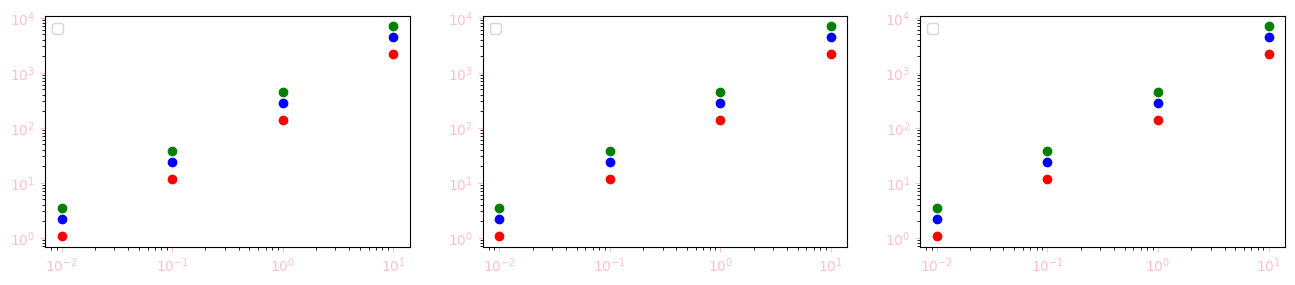

In [ ]:
fig,ax = plt.subplots(ncols=3,figsize=(16,3), constrained_layout = True, facecolor = 'white')

def flux_fct_eta(species, eta_var):
    result = np.ones_like(eta_var)
    for i in range(len(eta_var)):
        var_int = np.array([eta_var[i], kab0, kbc0, kac0, Eab0, Ebc0, Eac0, V0a, V0b, V0c, V1a, V1b, V1c, Aab, Abc, Aac, signA, signB, signC, 11., X0, Xf, n, dx])
        fint = physfcts(var_int)
        A_ooe = diff_flux(rho_a_ooe,fint.Va_out(X),dx)
        B_ooe = diff_flux(rho_b_ooe,fint.Vb_out(X),dx)
        C_ooe = diff_flux(rho_c_ooe,fint.Vc_out(X),dx)
        deltaint = fint.flux_cc(X[4999])-fint.flux_cw(X[4999])
        if species == 'A':
            result[i] = A_ooe[4999]/deltaint
        elif species == 'B':
            result[i] = B_ooe[4999]/deltaint
        elif species == 'C':
            result[i] = C_ooe[4999]/deltaint
    return result

eta_array = np.array([0.01,0.1,1,10.])

ax[0].loglog(eta_array,flux_fct_eta('A',eta_array),'o', color = ColorCycle[0])
ax[0].loglog(eta_array,flux_fct_eta('B',eta_array),'o', color = ColorCycle[1])
ax[0].loglog(eta_array,flux_fct_eta('C',eta_array),'o', color = ColorCycle[2])
ax[1].loglog(eta_array,flux_fct_eta('A',eta_array),'o', color = ColorCycle[0])
ax[1].loglog(eta_array,flux_fct_eta('B',eta_array),'o', color = ColorCycle[1])
ax[1].loglog(eta_array,flux_fct_eta('C',eta_array),'o', color = ColorCycle[2])
ax[2].loglog(eta_array,flux_fct_eta('A',eta_array),'o', color = ColorCycle[0])
ax[2].loglog(eta_array,flux_fct_eta('B',eta_array),'o', color = ColorCycle[1])
ax[2].loglog(eta_array,flux_fct_eta('C',eta_array),'o', color = ColorCycle[2])
